# Imports

---

In [55]:
import cv2
import numpy as np
from common_functions import *
from skimage.filters import threshold_minimum,threshold_otsu
from skimage.exposure import equalize_hist
from scipy.ndimage import binary_erosion,binary_closing,binary_opening,binary_dilation
from skimage import exposure
from skimage.measure import find_contours
from skimage.draw import rectangle


# Utils
---

In [56]:


def Erode(img,windowSize):
    window=np.ones((windowSize,windowSize))
    Final=np.zeros(img.shape)
    for i in range(img.shape[0]-windowSize+1):
        for j in range(img.shape[1]-windowSize+1):
            Fit=np.all(np.logical_and(window,img[i:i+windowSize,j:j+windowSize]))
            Final[i,j]=Fit
    return Final

def Dilate(img,windowSize):
    window=np.ones((windowSize,windowSize))
    Final=np.zeros(img.shape)
    for i in range(img.shape[0]-windowSize+1):
        for j in range(img.shape[1]-windowSize+1):
            Hit=np.any(np.logical_and(window,img[i:i+windowSize,j:j+windowSize]))
            Final[i,j]=Hit
    return Final 
def custom_erosion (image , window_size ):
    height ,  width  = image.shape 
    edge_y = window_size[0] // 2
    edge_x = window_size[1] // 2 
    window = np.ones(window_size) 
    out_image_erosion = np.zeros(image.shape)

    for y in range(edge_y , height - edge_y) :
        for x in range(edge_x , width - edge_x) :
            image_window = image [y-edge_y:y+edge_y+1,x-edge_x:x+edge_x+1] 
            multiplied_img = image_window*window
            out_image_erosion[y,x] = np.all(multiplied_img == 1) 
    return out_image_erosion 


def custom_dilation (image , window_size ):
    height ,  width  = image.shape 
    edge_y = window_size[0] // 2
    edge_x = window_size[1] // 2 
    window = np.ones(window_size) 
    out_image_dilation = np.zeros(image.shape)
    for y in range(edge_y , height - edge_y) :
        for x in range(edge_x , width - edge_x) :
            image_window = image [y-edge_y:y+edge_y+1,x-edge_x:x+edge_x+1] 
            multiplied_img = image_window*window
            out_image_dilation[y,x] = np.any(multiplied_img == 1) 
    return out_image_dilation
def Gamma_correction(img,gamma):
    img = img / img.max()
    img = img* 255
    img = img.astype(np.uint8)
    img = exposure.adjust_gamma(img, gamma)
    return img

def houghTransform(img):
    orgimg=img.copy()
    cdst = orgimg.copy()
    cdstP = np.copy(cdst)
    
    lines = cv2.HoughLines(orgimg, 1, np.pi / 180, 150, None, 0, 0)
    
    if lines is not None:
        for i in range(0, len(lines)):
            rho = lines[i][0][0]
            theta = lines[i][0][1]
            a = math.cos(theta)
            b = math.sin(theta)
            x0 = a * rho
            y0 = b * rho
            pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
            pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
            cv2.line(cdst, pt1, pt2, (255,255,255), 2, cv2.LINE_AA)
    
    
    linesP = cv2.HoughLinesP(orgimg, 1, np.pi / 180, 50, None, 50, 60)
    
    if linesP is not None:
        for i in range(0, len(linesP)):
            l = linesP[i][0]
            cv2.line(cdstP, (l[0], l[1]), (l[2], l[3]), (255,255,255), 2, cv2.LINE_AA)
    
    return cdstP

## `load_and_preprocess_image`
### Description
Loads the image, converts it to grayscale, and applies gamma correction.

### Parameters
- **`image_path`** *(str)*: Path to the input image file.

### Returns
- **`image`** *(ndarray)*: Original image.
- **`gray`** *(ndarray)*: Grayscale version of the image.
- **`gray_image`** *(ndarray)*: Gamma-corrected grayscale image.

---


In [57]:
def load_and_preprocess_image(image_path):
    """Loads the image, converts it to grayscale, and applies gamma correction."""
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_image = Gamma_correction(gray, 2.2)
    return image, gray, gray_image

## `reduce_noise`
### Description
Applies noise reduction techniques to the grayscale image.

### Parameters
- **`gray_image`** *(ndarray)*: Gamma-corrected grayscale image.

### Returns
- **`blurred`** *(ndarray)*: Noise-reduced grayscale image.

---


In [58]:
def reduce_noise(gray_image):
    """Applies noise reduction techniques to the grayscale image."""
    blurred = cv2.bilateralFilter(gray_image, 80, 50, 5)
    blurred = cv2.GaussianBlur(blurred, (11, 11), 0)
    return blurred


## `threshold_and_edge_detection`
### Description
Applies thresholding and edge detection to preprocess the image for contour detection.

### Parameters
- **`gray_image`** *(ndarray)*: Gamma-corrected grayscale image.

### Returns
- **`edges`** *(ndarray)*: Image with edges highlighted after thresholding and dilation.

---

In [59]:

def threshold_and_edge_detection(gray_image):
    """Applies thresholding and edge detection to preprocess the image for contour detection."""
    threshold = threshold_minimum(gray_image)
    mask = gray_image > threshold
    binary_image = np.zeros(gray_image.shape)
    binary_image[mask] = 255
    binary_image = binary_image.astype(np.uint8)
    edges = canny(binary_image, sigma=50, low_threshold=0.5, high_threshold=0.6)
    return Dilate(edges, 5)

## `filter_reciept_contours`
### Description
Filters contours to find a rectangular contour with 4 corners and a large area.

### Parameters
- **`contours`** *(list)*: List of contours detected in the image.

### Returns
- **`rectangular_contours`** *(list)*: Contours that are rectangular.
- **`reciept_contour`** *(ndarray)*: Contour of the detected reciept with the largest area.

---


In [60]:

def filter_reciept_contours(contours):
    """Filters contours to find a rectangular contour with 4 corners and a large area."""
    rectangular_contours = []
    max_area = 0
    reciept_contour = None
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 30000:
            peri = cv2.arcLength(contour, True)
            approx_polygon = cv2.approxPolyDP(contour, 0.015 * peri, True)
            if area > max_area and len(approx_polygon) == 4:
                rectangular_contours.append(approx_polygon)
                reciept_contour = approx_polygon
                max_area = area
    return rectangular_contours, reciept_contour

In [61]:

def process_image_iteration(preProcessedImage, edges, iterations):
    """Processes the image for a given iteration using various transformations."""
    if iterations == 0:
        return edges
    elif iterations == 1:
        preProcessedImage = cv2.dilate(preProcessedImage, np.ones((3, 3)))
        return cv2.erode(preProcessedImage, np.ones((3, 3)))
    elif iterations == 2:
        return houghTransform(preProcessedImage)
    else:
        preProcessedImage = houghTransform(preProcessedImage)
        preProcessedImage = cv2.erode(preProcessedImage, np.ones((3, 3)))
        preProcessedImage = cv2.dilate(preProcessedImage, np.ones((3, 3)))
        preProcessedImage = cv2.dilate(preProcessedImage, np.ones((7, 7)))
        return cv2.erode(preProcessedImage, np.ones((7, 7)))

## `apply_iterations`
### Description
Iteratively processes the image using various transformations until contours are found.

### Parameters
- **`preProcessedImage`** *(ndarray)*: Image to process during iterations.
- **`edges`** *(ndarray)*: Image with detected edges.

### Returns
- **`preProcessedImage`** *(ndarray)*: Processed image after iterations.
- **`contours`** *(list)*: List of contours detected in the processed image.

---

In [62]:

def apply_iterations(preProcessedImage, edges):
    """Iteratively processes the image using various transformations until contours are found."""
    for iterations in range(8):
        preProcessedImage = process_image_iteration(preProcessedImage, edges, iterations)

        if preProcessedImage.dtype != np.uint8:
            preProcessedImage = (preProcessedImage * 255).astype(np.uint8)

        contours, _ = cv2.findContours(preProcessedImage, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(filter_reciept_contours(contours)) > 0:
            return preProcessedImage, contours

    return preProcessedImage, []


## `find_polygon_corners`
### Description
Identifies the corners of the detected polygon.

### Parameters
- **`reciept_contour`** *(ndarray)*: Contour of the detected reciept.

### Returns
- **`input_points`** *(ndarray)*: Array containing the four corner points of the detected polygon.

---

In [63]:

def find_polygon_corners(reciept_contour):
    """Identifies the corners of the detected polygon."""
    points = reciept_contour.reshape(4, 2)
    input_points = np.zeros((4, 2), dtype="float32")
    points_sum = points.sum(axis=1)
    input_points[0] = points[np.argmin(points_sum)]
    input_points[3] = points[np.argmax(points_sum)]
    points_diff = np.diff(points, axis=1)
    input_points[1] = points[np.argmin(points_diff)]
    input_points[2] = points[np.argmax(points_diff)]
    return input_points

## `transform_perspective`
### Description
Performs a perspective transformation on the image.

### Parameters
- **`image`** *(ndarray)*: Original image.
- **`input_points`** *(ndarray)*: Four corner points of the detected polygon.

### Returns
- **`img_output`** *(ndarray)*: Perspective-transformed output image of the detected reciept.

---


In [64]:

def transform_perspective(image, input_points):
    """Performs a perspective transformation on the image."""
    max_width = 1024
    max_height = 650
    converted_points = np.float32([[0, 0], [max_width, 0], [0, max_height], [max_width, max_height]])
    matrix = cv2.getPerspectiveTransform(input_points, converted_points)
    img_output = cv2.warpPerspective(image, matrix, (max_width, max_height))
    return img_output

## `find_reciept`
### Description
Main function to detect a reciept in an image and return the transformed perspective.

### Parameters
- **`image_path`** *(str)*: Path to the input image file.

### Returns
- **`img_output`** *(ndarray)*: Perspective-transformed output image of the detected reciept. 
  If no reciept is detected, the original image is returned.

In [65]:
def find_reciept(image_path):
    """Main function to detect a reciept in an image and return the transformed perspective."""
    image, gray, gray_image = load_and_preprocess_image(image_path)
    blurred = reduce_noise(gray)
    edges = threshold_and_edge_detection(gray_image)
    preProcessedImage, contours = apply_iterations(edges, edges)
    rectangular_contours, reciept_contour = filter_reciept_contours(contours)

    if len( reciept_contour) == 0:
        return image

    input_points = find_polygon_corners(reciept_contour)
    img_output = transform_perspective(image, input_points)
    return img_output


# Testing

---

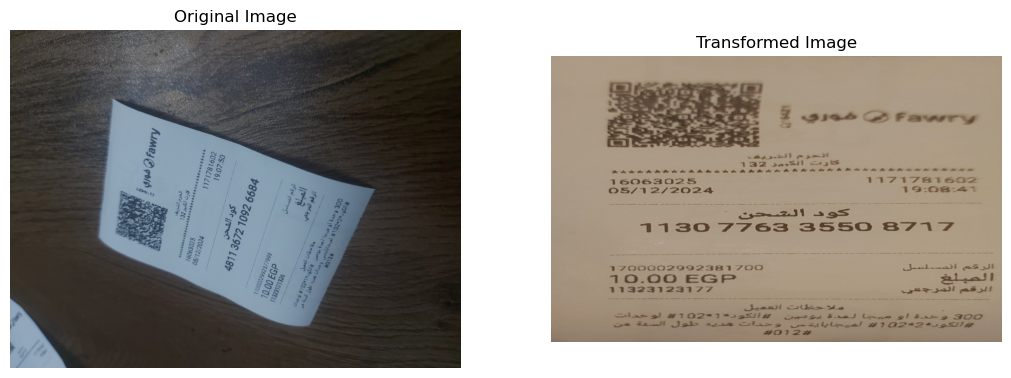

In [66]:
# base_path = "../imgs/"
# min_image_index = 1
# max_image_index = 24
# for i in range(min_image_index, max_image_index + 1):
#     image_path = base_path + str(i) + ".jpg"
#     image = cv2.imread(image_path)
#     reciept = find_reciept(image)
#     show_images([image, reciept], ["Original Image"+str(i), "Transformed Image"+str(i)])
   

image = io.imread("../imgs/13.jpg")
reciept = find_reciept("../imgs/20.jpg")
show_images([image, reciept], ["Original Image", "Transformed Image"])

# Extraxct Number
---
(Not finished yet)

68


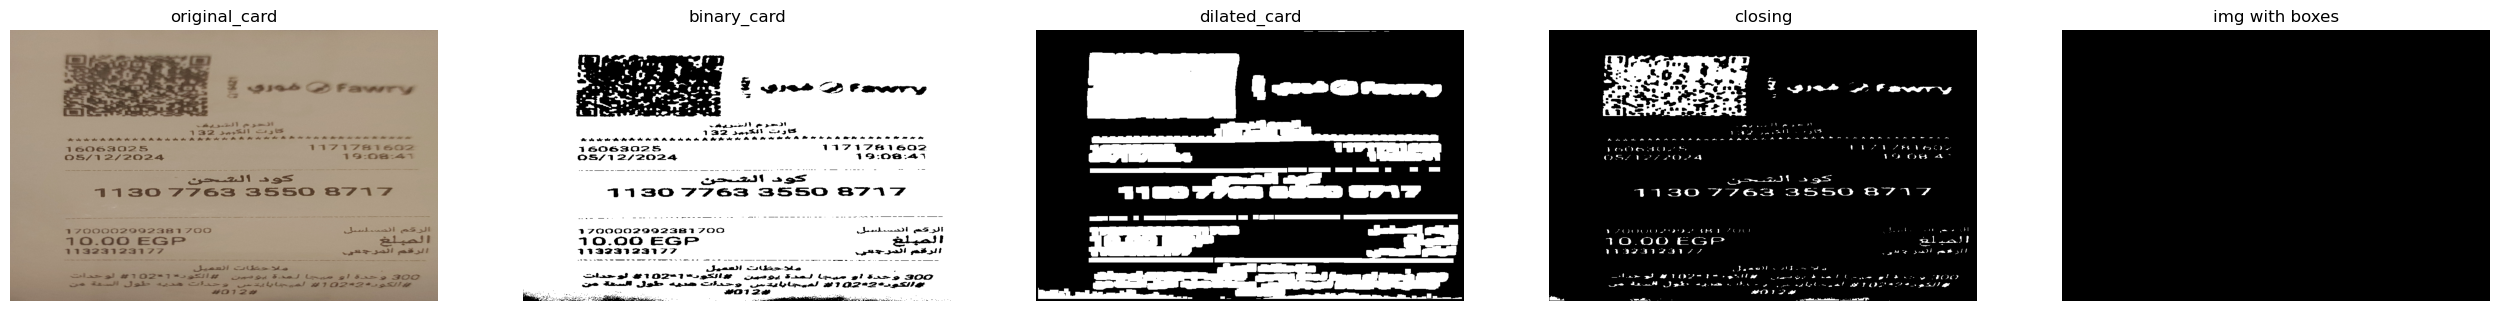

In [67]:

grey_card = rgb2gray(reciept)
binary_card = grey_card > 0.5 
negated_binary_card = np.logical_not(binary_card)
dilated_card = custom_dilation(negated_binary_card,(11,11)) 
closing = custom_erosion(negated_binary_card , (3,3))

contours = find_contours(closing , 0.8)  
bounding_boxes =[]
for contour in contours : 
    x_min = np.min(contour[:, 1])
    x_max = np.max(contour[:, 1])
    y_min = np.min(contour[:, 0])
    y_max = np.max(contour[:, 0])

    bounding_box = [x_min, x_max, y_min, y_max]

    horizontal = x_max - x_min
    vertical = y_max - y_min

    detected_aspect_ratio = horizontal/vertical

    if (detected_aspect_ratio >=  2.5) and (detected_aspect_ratio <=  3.5) :
        bounding_boxes.append(bounding_box)
print(len(bounding_boxes))
img_with_boxes = np.zeros_like(closing)
#When provided with the correct format of the list of bounding_boxes, this section will set all pixels inside boxes in img_with_boxes
for box in bounding_boxes:
    [Xmin, Xmax, Ymin, Ymax] = box
    rr, cc = rectangle(start = (Ymin,Xmin), end = (Ymax,Xmax), shape=grey_card.shape)
    img_with_boxes[rr, cc] = 0 #set color white 
show_images ([reciept, binary_card ,dilated_card, closing,img_with_boxes], ['original_card', 'binary_card' ,'dilated_card', 'closing','img with boxes']) 